In [1]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import truncgauss
from scipy.spatial import distance_matrix
import pandas as pd
from joblib import Parallel, delayed
import psutil
from sklearn import metrics
import scipy.integrate as integrate
import sys
import os
from sklearn.gaussian_process.kernels import Matern
from scipy.spatial.distance import pdist

#################################################################### Loading GNM ####################################################################
model_version = 0
target_distribution = ""
base_nn = "VAEGAN"
sys.path.append('../')
import glms
import pickle
import torch
path_ = f"Checkpoints/{base_nn}{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/VAEGAN/lightning_logs/version_0/checkpoints/epoch=46-step=7567-val_fid=181.166.ckpt'
print([path_,ckpt_path])

GNM_output = pickle.load( open(os.path.join(path_,"test_output_1999_2019-07.pkl"),"rb") )

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


['Checkpoints/VAEGAN/lightning_logs/version_0/', 'Checkpoints/VAEGAN/lightning_logs/version_0/checkpoints/epoch=46-step=7567-val_fid=181.166.ckpt']


In [2]:
locations_x = []
locations_y = []
indexes_land = []
for y_loc in range(100):
    for x_loc in range(140):
        if GNM_output['mask'][3][y_loc,x_loc]==True:
            if 100-y_loc>-18.75+(25/80)*x_loc:
                locations_x.append(x_loc)
                locations_y.append(-y_loc)
                indexes_land.append([y_loc,x_loc])

GNM_output.keys()

dict_keys(['pred_rain_mean', 'target_rain', 'mask', 'target_date_window', 'pred_rain_ensemble'])

# Warwing: check if the correct locations were removed

# Diagnostics

### Marginals

In [46]:
# Draw time-series plot with quantiles for predicted vs trget rain at a given location. ~3s 
# Just change values at the top.

#ts_plot_location = 3055
for ts_plot_location in [954]:
    print(ts_plot_location)
    ts_plot_left_lim,ts_plot_right_lim = ts_plot_location+0,ts_plot_location+0+360

    #################################################################### Do not touch the rest ####################################################################
    import matplotlib.dates as mdates

    # mean and 68, 95 percentiles 
    g_median = []
    g_q25 = []
    g_q75 = []
    g_q68 = []
    g_q95 = []
    g_q32 = []
    g_q05 = []

    #GNM_landonly[location][param][day]
    # 0'pred_alpha', 1'pred_beta', 2 rain>0 , 3'target_rain', 4 pred_p, 5 loc
    for a,b,i in zip([GNM_landonly[ts_plot_location][0][i] for i in range(len(GNM_landonly[0][0]))],[GNM_landonly[ts_plot_location][1][i] for i in range(len(GNM_landonly[0][0]))],range(len(GNM_landonly[0][0]))) :
        rv = scs.gamma(scale=1/b,a=a)  
        
        g_median.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.5)/GNM_landonly[ts_plot_location][4][i]))
        g_q25.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.25)/GNM_landonly[ts_plot_location][4][i]))
        g_q75.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.75)/GNM_landonly[ts_plot_location][4][i]))
        g_q95.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.95)/GNM_landonly[ts_plot_location][4][i]))
        g_q05.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.05)/GNM_landonly[ts_plot_location][4][i]))

    for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
        for i in range(len(q)):
            if math.isnan(q[i]):
                q[i]=0
                
    plt.figure(figsize=(25, 8),dpi=700)
    plt.plot(day_dates,g_q05,color='skyblue',linewidth=0.6,alpha=1,label='forecast percentiles 05 to 95')
    plt.plot(day_dates,g_q25,color='navy',linewidth=0.6,alpha=1,label='forecast percentiles 25 to 75')
    plt.plot(day_dates,g_median,color='blue',linewidth=1,alpha=1,label='forcast median')
    plt.plot(day_dates,g_q75,color='navy',linewidth=0.6,alpha=1)
    plt.plot(day_dates,g_q95,color='skyblue',linewidth=0.6,alpha=1)
    plt.fill_between(day_dates, g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
    plt.fill_between(day_dates, g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
    plt.scatter(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',marker='1',s=20,label='observed rain')
    plt.plot(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',alpha=0.6,linewidth=0.3)
    plt.xlim((day_dates[ts_plot_left_lim],day_dates[ts_plot_right_lim]))
    plt.title('Gamma model at location '+str(GNM_landonly[ts_plot_location][5]))
    plt.xlabel('Day index')
    plt.ylabel('Precipitation (mm)')
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

954


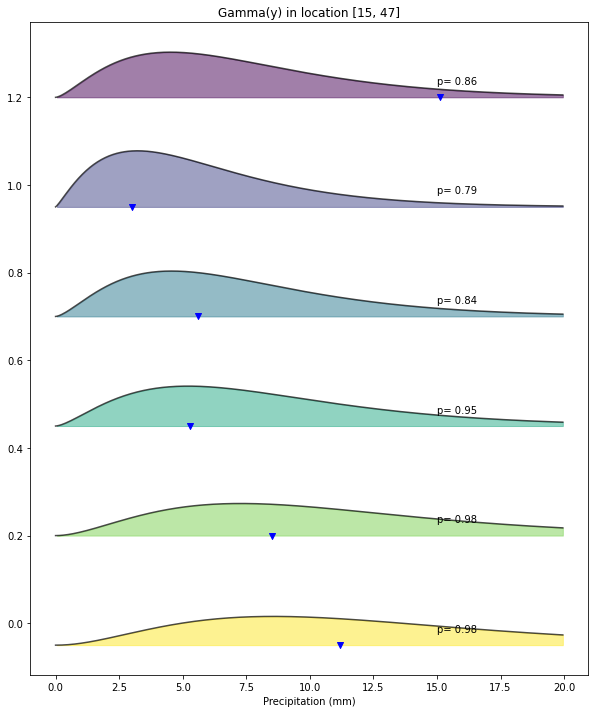

In [47]:
# Densities plots
# Just change values at the top.

density_plot_location = 111
density_plot_start,density_plot_end = 370,376

#################################################################### Do not touch the rest ####################################################################
import matplotlib

# 0'pred_alpha', 1'pred_beta', 2 rain>0 , 3'target_rain', 4 pred_p, 5 loc
x=[i/20 for i in range(400)]
plt.figure(figsize=(10,(density_plot_end-density_plot_start)*2))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(density_plot_end,density_plot_start,-1))))
for idx,col in zip(reversed(range(density_plot_start-1,density_plot_end)),colors):
    rv=scs.gamma(a=[GNM_landonly[density_plot_location][0][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],scale=[1/GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx])
    level=(-0.3+(idx+1-density_plot_start)*0.25)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.03,'p= '+str(round([GNM_landonly[density_plot_location][4][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],2)))
    plt.scatter([GNM_landonly[density_plot_location][3][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.title('Gamma(y) in location '+str(GNM_landonly[density_plot_location][5]))
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],reversed([pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date'][density_plot_start:density_plot_end]]))
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[k for k in range([density_plot_start:density_plot_end]])
plt.show()

### Median forecast

In [102]:
day_subset = np.random.choice(range(len(GNM_output['target_rain'])),size=256,replace=False)



In [103]:
all_sims = np.array([np.array([GNM_output['pred_rain_ensemble'][d][i[0]][i[1]] for i in indexes_land]) for d in tqdm(range(len(GNM_output['pred_rain_ensemble']))) ])
# all_sims[day,loc,sim]

100%|██████████| 7486/7486 [01:09<00:00, 107.37it/s]


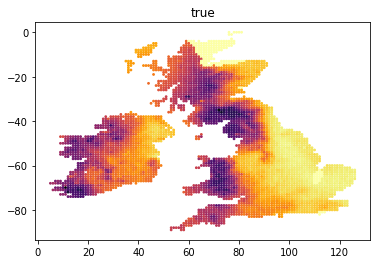

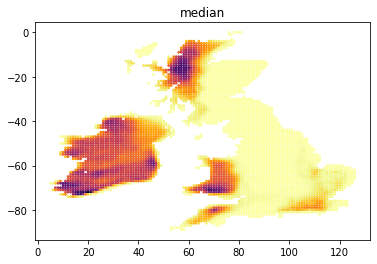

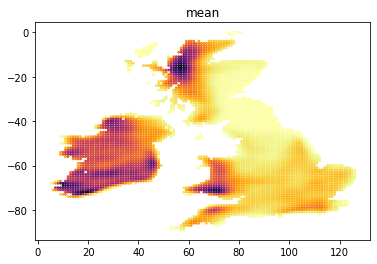

In [104]:
for d in range(1):
    plt.scatter(locations_x,locations_y,c=[GNM_output['target_rain'][d][i[0],i[1]] for i in indexes_land],cmap='inferno_r',s=3)
    plt.title('true')
    plt.show()
    plt.scatter(locations_x,locations_y,c=np.median(all_sims[d],axis=1),cmap='inferno_r',s=3)
    plt.title('median')
    plt.show()
    plt.scatter(locations_x,locations_y,c=np.mean(all_sims[d],axis=1),cmap='inferno_r',s=3)
    plt.title('mean')
    plt.show()

### ROC

In [48]:
def fast_roc(day,x):
   
   out = 1-(
         (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])) + 
         np.multiply(
            [GNM_landonly[l][4][day] for l in range(len(GNM_landonly))] , 
            scs.gamma( scale=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))] , 
                        a=[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))]
               ).cdf(x)
            )        
      )

   return out

In [49]:
# getting vector of 'did it rain this much'
g_0mm=[]
g_5mm=[]
g_10mm=[]
g_15mm=[]
g_20mm=[]
g_25mm=[]

#GNM_landonly[location][param][day]
# 0'pred_alpha', 1'pred_beta', 2 rain>0 , 3'target_rain', 4 pred_p, 5 loc

def fast_roc(day,x):
   
   out = 1-(
         (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])) + 
         np.multiply(
            [GNM_landonly[l][4][day] for l in range(len(GNM_landonly))] , 
            scs.gamma( scale=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))] , 
                        a=[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))]
               ).cdf(x)
            )        
      )

   return out


for d in tqdm(range(len(GNM_landonly[0][0]))):
   g_0mm.append(fast_roc(d,0.01))
   g_5mm.append(fast_roc(d,5))
   g_10mm.append(fast_roc(d,10))
   g_15mm.append(fast_roc(d,15))
   g_20mm.append(fast_roc(d,20))
   g_25mm.append(fast_roc(d,25))


with open('g_0mm.txt','wb') as f:
   pickle.dump(g_0mm,f)

with open('g_5mm.txt','wb') as f:
   pickle.dump(g_5mm,f)

with open('g_10mm.txt','wb') as f:
   pickle.dump(g_10mm,f)

with open('g_15mm.txt','wb') as f:
   pickle.dump(g_15mm,f)

with open('g_20mm.txt','wb') as f:
   pickle.dump(g_20mm,f)

with open('g_25mm.txt','wb') as f:
   pickle.dump(g_25mm,f)


100%|██████████| 7486/7486 [16:42<00:00,  7.47it/s]


In [50]:
g_0mm_did_rain=[]
g_5mm_did_rain=[]
g_10mm_did_rain=[]
g_15mm_did_rain=[]
g_20mm_did_rain=[]
g_25mm_did_rain=[]
def roc_didrain(day,x):
    return np.array([GNM_landonly[l][3][day] for l in range(len(GNM_landonly))])>x
for d in tqdm(range(len(GNM_landonly[0][0]))):
   g_0mm_did_rain.append(roc_didrain(d,0.01))
   g_5mm_did_rain.append(roc_didrain(d,5))
   g_10mm_did_rain.append(roc_didrain(d,10))
   g_15mm_did_rain.append(roc_didrain(d,15))
   g_20mm_did_rain.append(roc_didrain(d,20))
   g_25mm_did_rain.append(roc_didrain(d,25))

100%|██████████| 7486/7486 [01:25<00:00, 87.53it/s] 


In [ ]:
#Saving data
'''with open('g_0mm.txt','wb') as f:
    pickle.dump(g_0mm,f)
with open('g_5mm.txt','wb') as f:
    pickle.dump(g_5mm,f)
with open('g_10mm.txt','wb') as f:
    pickle.dump(g_10mm,f)
with open('g_15mm.txt','wb') as f:
    pickle.dump(g_15mm,f)
with open('g_20mm.txt','wb') as f:
    pickle.dump(g_20mm,f)
with open('g_25mm.txt','wb') as f:
    pickle.dump(g_25mm,f)'''

# Loading data
 
with open('g_0mm.txt','rb') as f:
    g_0mm = pickle.load(f)
with open('g_5mm.txt','rb') as f:
    g_5mm = pickle.load(f)
with open('g_10mm.txt','rb') as f:
    g_10mm = pickle.load(f)
with open('g_15mm.txt','rb') as f:
    g_15mm = pickle.load(f)
with open('g_20mm.txt','rb') as f:
    g_20mm = pickle.load(f)
with open('g_25mm.txt','rb') as f:
    g_25mm = pickle.load(f)

In [51]:
# Restructuring data for ROC ~1m+3m/20y , 6m/30y

# g_25mm[loc][parallel run][0:rained more than x, 1:P it rained x][days]
roc_0_tf = np.array(g_0mm_did_rain).flatten()
roc_0_p = np.array(g_0mm).flatten()

roc_5_tf = np.array(g_5mm_did_rain).flatten()
roc_5_p = np.array(g_5mm).flatten()

roc_10_tf = np.array(g_10mm_did_rain).flatten()
roc_10_p = np.array(g_10mm).flatten()

roc_15_tf = np.array(g_15mm_did_rain).flatten()
roc_15_p = np.array(g_15mm).flatten()

roc_20_tf = np.array(g_20mm_did_rain).flatten()
roc_20_p = np.array(g_20mm).flatten()

roc_25_tf = np.array(g_25mm_did_rain).flatten()
roc_25_p = np.array(g_25mm).flatten()

###

fpr_0mm, tpr_0mm, _ = metrics.roc_curve(roc_0_tf,roc_0_p)
auc0 = metrics.roc_auc_score(roc_0_tf,roc_0_p)

fpr_5mm, tpr_5mm, _ = metrics.roc_curve(roc_5_tf,roc_5_p)
auc5 = metrics.roc_auc_score(roc_5_tf,roc_5_p)

fpr_10mm, tpr_10mm, _ = metrics.roc_curve(roc_10_tf,roc_10_p)
auc10 = metrics.roc_auc_score(roc_10_tf,roc_10_p)

fpr_15mm, tpr_15mm, _ = metrics.roc_curve(roc_15_tf,roc_15_p)
auc15 = metrics.roc_auc_score(roc_15_tf,roc_15_p)

fpr_20mm, tpr_20mm, _ = metrics.roc_curve(roc_20_tf,roc_20_p)
auc20 = metrics.roc_auc_score(roc_20_tf,roc_20_p)

fpr_25mm, tpr_25mm, _ = metrics.roc_curve(roc_25_tf,roc_25_p)
auc25 = metrics.roc_auc_score(roc_25_tf,roc_25_p)

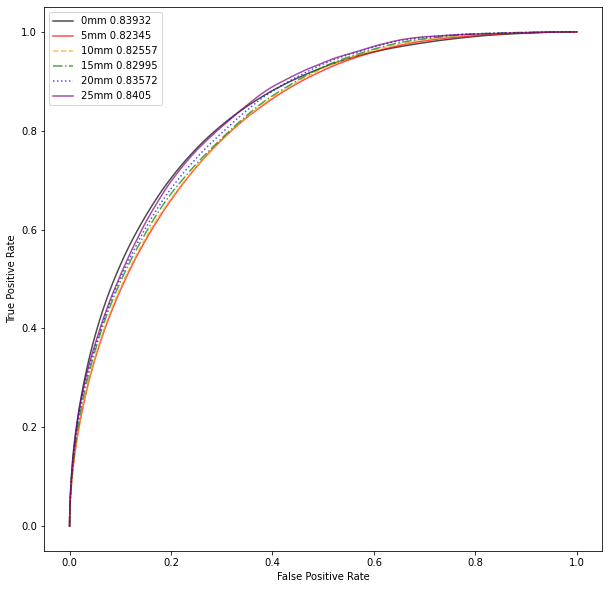

In [52]:
# ROC plot ~3m
plt.figure(figsize=(10,10))
plt.plot(fpr_0mm,tpr_0mm,label='AUC='+str(auc0),color='black',alpha=0.7)

plt.plot(fpr_5mm,tpr_5mm,label='AUC='+str(auc5),color='red',alpha=0.7)

plt.plot(fpr_10mm,tpr_10mm,label='AUC='+str(auc10),color='orange',alpha=0.7,linestyle='dashed')

plt.plot(fpr_15mm,tpr_15mm,label='AUC='+str(auc15),color='green',alpha=0.7,linestyle='dashdot')

plt.plot(fpr_20mm,tpr_20mm,label='AUC='+str(auc20),color='blue',alpha=0.7,linestyle='dotted')

plt.plot(fpr_25mm,tpr_25mm,label='AUC='+str(auc25),color='purple',alpha=0.7)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['0mm '+str(round(auc0,5)),'5mm '+str(round(auc5,5)),'10mm '+str(round(auc10,5)),'15mm '+str(round(auc15,5)),'20mm '+str(round(auc20,5)),'25mm '+str(round(auc25,5))])
#plt.title('Gamma Model United Kingdom')
#plt.savefig('ROC Gamma model UK')

### Precision-Recall Curve

### Spread-Skill

In [ ]:
# Spread-Skill but with variance as spread directly.
 
RMS_spread = [] # should get 2002 entries, each being the average RMS across all locations and draws, for that day.
RMS_skill = [] # should get 2002 entries, each being the average RMS across all locations, for that day.

for day in tqdm(range(len(GNM_landonly[0][1]))):
    # The expression used below is the RMS spread for one day: a single number, the average variance across all locations.
    RMS_spread.append(
        np.mean( # average over samples and locations 
             [(GNM_landonly[loc][4][day]*np.power(GNM_landonly[loc][0][day],2)*(GNM_landonly[loc][1][day]+1) - np.power(GNM_landonly[loc][4][day],2)*np.power(GNM_landonly[loc][0][day],2)) for loc in range(len(GNM_landonly))
                ]))
    
    # The expression below is the RMS skill for one day: a single number giving the average across all locations of the squared difference of median forecast and target
    RMS_skill.append(
        np.mean( # average over locations
            np.power( # square
                np.subtract( # difference
                    np.transpose(np.array(g_median_all).reshape((len(GNM_landonly),7301)))[day,:] # median for that day across all locations
                    ,[GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))] ) # target rain for that day across all locations
                    ,2) # square
                    ))

100%|██████████| 7301/7301 [18:33<00:00,  6.55it/s]


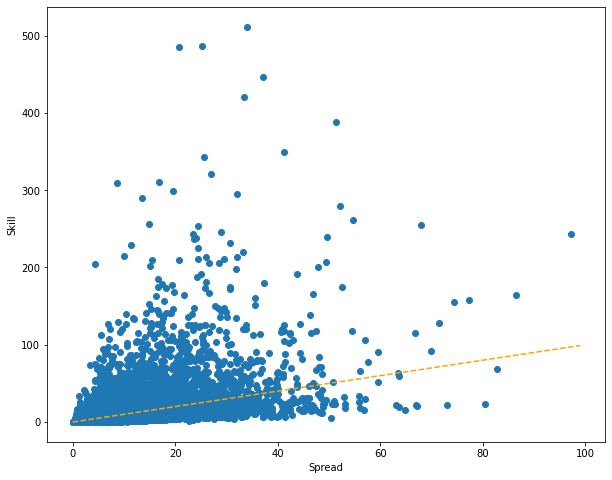

In [ ]:
# Skill-Spread over all days
plt.figure(figsize=(10,8))
plt.scatter(RMS_spread,RMS_skill)
plt.plot(range(100),range(100),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')

plt.show()

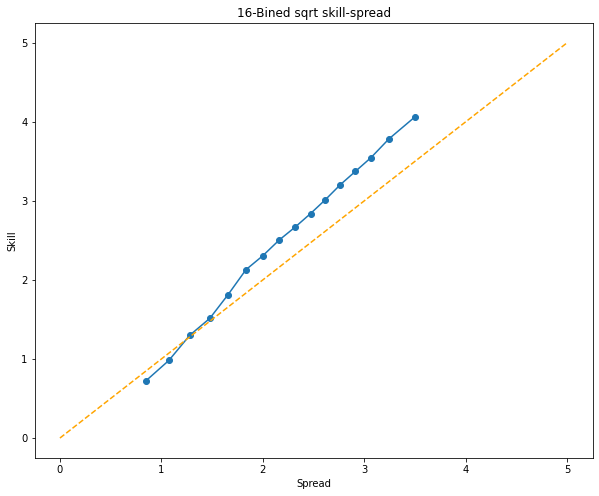

Text(0.5, 0, 'Spread')

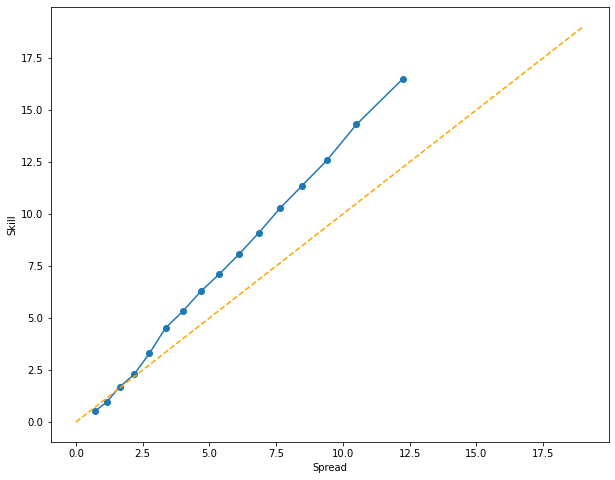

In [ ]:
# 16-Bined skill-spread - Need to draw samples of u first. 
# They are then used for each day.
binned_skill = [math.sqrt(np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
binned_spread = [math.sqrt(np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
plt.figure(figsize=(10,8))
plt.plot(binned_spread,binned_skill,'-o')
plt.plot(range(6),range(6),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')
plt.title('16-Bined sqrt skill-spread')
#plt.xlim(10,25)
#plt.ylim(5,20)
plt.show()
binned_skill = [np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
binned_spread = [np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
plt.figure(figsize=(10,8))

plt.plot(binned_spread,binned_skill,'-o')
plt.plot(range(20),range(20),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')


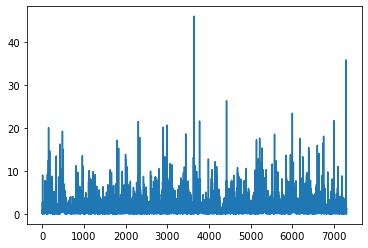

In [ ]:
plt.plot(np.divide(RMS_skill,RMS_spread))

### 1 - ecdf

100%|██████████| 7486/7486 [00:13<00:00, 546.23it/s]


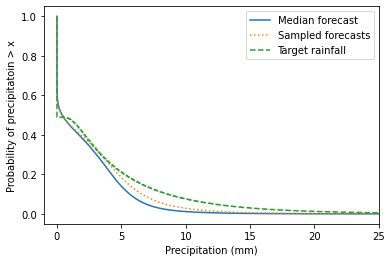

In [107]:
# P(rain>x) ~1m15 now. depending on samples and days used. 
from statsmodels.distributions.empirical_distribution import ECDF

# get empirical cdfs for median, sampled and target rain.
gamma_ecdf = ECDF(np.array([np.median(all_sims[d],axis=1) for d in day_subset]).flatten())
target_ecdf = ECDF(np.array([[GNM_output['target_rain'][d][i[0],i[1]] for i in indexes_land] for d in tqdm(range(len(GNM_output['target_rain'])))]).flatten())
gamma_sampled_ecdf = ECDF(all_sims[day_subset].flatten())
plt.plot(gamma_ecdf.x,1-gamma_ecdf.y,label='Median forecast')
plt.plot(gamma_sampled_ecdf.x,1-gamma_sampled_ecdf.y,linestyle='dotted',label='Sampled forecasts')
plt.plot(target_ecdf.x,1-target_ecdf.y,linestyle='--',label='Target rainfall')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability of precipitatoin > x')
plt.xlim(-1,25)
plt.legend()

### RMSB MAB

In [130]:
# RMSB and MAB metrics across sub sampled locations and all days 

# all_sims[day][loc][sim]
subdays_target_rain = np.array([[GNM_output['target_rain'][d][i[0],i[1]] for i in indexes_land] for d in day_subset])
subdays_median = np.array([np.median(all_sims[d],axis=1) for d in day_subset])

RMSB = math.sqrt(np.mean(np.power(np.subtract(subdays_target_rain,subdays_median),2)))
MAB = np.mean(np.abs(subdays_median,subdays_target_rain))
print('MAB = '+str(MAB)+', RMSB = '+str(RMSB))

MAB = 1.8877654, RMSB = 4.815604855583779


### Median VS Observed

In [15]:
# median vs observed
binned_median_means = [np.log(np.mean(g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])+1) for k in range(30)]
binned_median_std = [np.std(np.log(1+g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])) for k in range(30)]

plt.plot(np.log([i for i in range(1,30*3,3)]),binned_median_means, color='red',linestyle='dashed',label='Mean/SD of pred in 3mm/day intervals')

for i,v in enumerate(range(1,30*3,3)):
    if i==0:
        continue
    plt.plot(np.log([v,v]),[binned_median_means[i]+binned_median_std[i] ,binned_median_means[i]-binned_median_std[i] ],'r',linewidth=1)

plt.plot([0,5],[0,5],linestyle='dashed',color='grey',label='y = x')
plt.scatter(np.log(all_target_rain.flatten()+1),np.log(g_median_all+1),marker='x',linewidths=0.3,alpha=0.3)

plt.axvline(x = np.log(10), color = 'purple', label = '10 mm rainfall',linewidth=1.3)

plt.legend(loc='upper left')

plt.xlabel('Observed log-trandformed rainfall')
plt.ylabel('Predicted log-trandformed rainfall')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7486 but corresponding boolean dimension is 35977716

### CRPS

In [ ]:
# compute CRPS per locatoin. This is done in the medium benchmark paper. Also, I can then plot CRPs on a map, could be nice.

In [16]:
def estimate_CRPS_score(observation, simulations):
    """observation is a single value, while simulations is an array. We estimate this by building an empirical
    unbiased estimate of Eq. (1) in Ziel and Berk 2019"""
    diff_X_y = np.abs(observation - simulations)
    n_sim = simulations.shape[0]
    diff_X_tildeX = np.abs(simulations.reshape(1, -1) - simulations.reshape(-1, 1))
    return 2 * np.mean(diff_X_y) - np.sum(diff_X_tildeX) / (n_sim * (n_sim - 1))

def exact_CRPS_score(y_obs,F):
    def I(x):
        return np.power(F(x)-(x>y_obs),2)
    return integrate.quad(lambda x: I(x), -0.1,10e+3)[0]
    

In [139]:
def estimate_CRPS_score_fast(obs,sims):
    '''
    obs: one vector of observations [y_1, y_2, ... y_n], ideally n corresponds to locations.
    sims: m vectors of simulations, each vector has length n. [[x_11, x_21,..., x_n1] ,..., [x_1m, x_2m,..., x_nm] ]

    returns: a vector [s1, ... , sn] of one score per location. this is for a single day, so would still need to average across days.
    '''
    m = len(sims)

    obs= np.array(obs)
    sims=np.array(sims)

    # |X-x|    
    diff_X_x = np.mean(
        np.abs(
            np.tile(obs,(m,1)) - sims
            ),
        axis=0)

    #|X-X'|
    diff_X_tilde_X = np.sum(
        np.abs(
            np.tile(sims,(m,1))-
            np.repeat(sims,m,axis=0)
            )
            ,axis=0
        )/(m*m-1)

    return 2*diff_X_x - diff_X_tilde_X 


In [137]:
np.transpose(all_sims[day_subset[0]]).shape

(25, 4302)

In [153]:
q_crps = []

for day_idx,day in tqdm(enumerate(day_subset)):
    q_crps.append( estimate_CRPS_score_fast(subdays_target_rain[day_idx],np.transpose(all_sims[day])) )

256it [00:03, 77.96it/s]


In [154]:
# Mean CRPS:
np.mean(q_crps)

4.485355

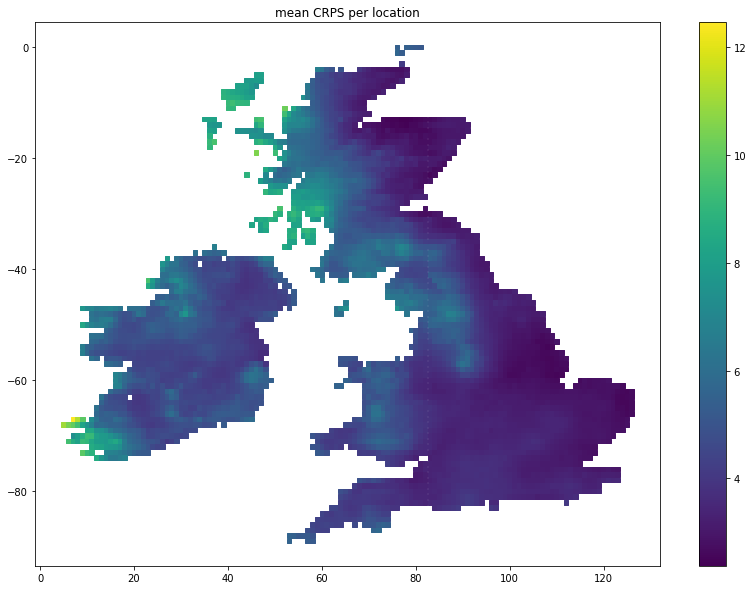

In [155]:
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.scatter(locations_x,locations_y,c=np.mean(q_crps,axis=0),s=22,marker='s')
plt.colorbar()
plt.title('mean CRPS per location')
plt.show()


### Spatial Scoring Rule

In [163]:
def Spatial_Energy_Score_single_day(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return [2 * np.mean(diff_Y_y), np.sum(diff_Y_Y)/(m*(m-1))]

In [160]:
Energy_diagnostic = []
for i,d in tqdm(enumerate(range(256))):
    Energy_diagnostic.append(Spatial_Energy_Score_single_day(2,subdays_target_rain[d],np.transpose(all_sims[i])) )

256it [00:00, 565.68it/s]


In [164]:
Spatial_Energy_Score_single_day(2,subdays_target_rain[d],np.transpose(all_sims[i])) 

[149422.625, 50833.035783187974]

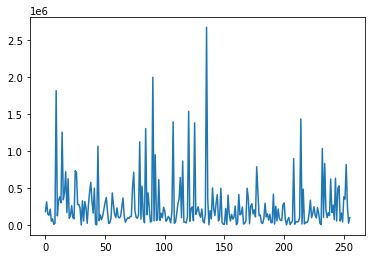

In [161]:
plt.plot(Energy_diagnostic)

In [162]:
np.mean(Energy_diagnostic)

256890.3348620943

### Fraction Skill Score (FSS)

### Rank histogram

In [40]:
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

def get_cdf_gnm(day):
    p_times_cdf = np.multiply( #p*cdf(y)
        np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))]),
        scs.gamma(
            a=[GNM_landonly[l][0][day] for l in range(len(GNM_landonly))],
            scale=[1/GNM_landonly[l][1][day] for l in range(len(GNM_landonly))]
            ).cdf([GNM_landonly[l][3][day] for l in range(len(GNM_landonly))]))
    
    where_0 = np.argwhere(p_times_cdf==0).flatten()
    where_rain = np.argwhere(p_times_cdf>0).flatten()

    p_times_cdf[where_0] = np.random.uniform( # replace censored by u~[0,1-p]
        low=np.zeros(len(where_0)),
        high=(1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))])[where_0]).flatten()
        )
    
    p_times_cdf[where_rain] = (1-np.array([GNM_landonly[l][4][day] for l in range(len(GNM_landonly))]))[where_rain] + p_times_cdf[where_rain] # uncensored = (1-p) + p*cdf(y)

    return p_times_cdf

In [41]:
obs_u_all = []
for d in tqdm(range(len(GNM_landonly[0][0]))):
    obs_u_all.append(get_cdf_gnm(d))

100%|██████████| 7486/7486 [04:00<00:00, 31.08it/s]


In [42]:
obs_u_all = np.array(obs_u_all).flatten()

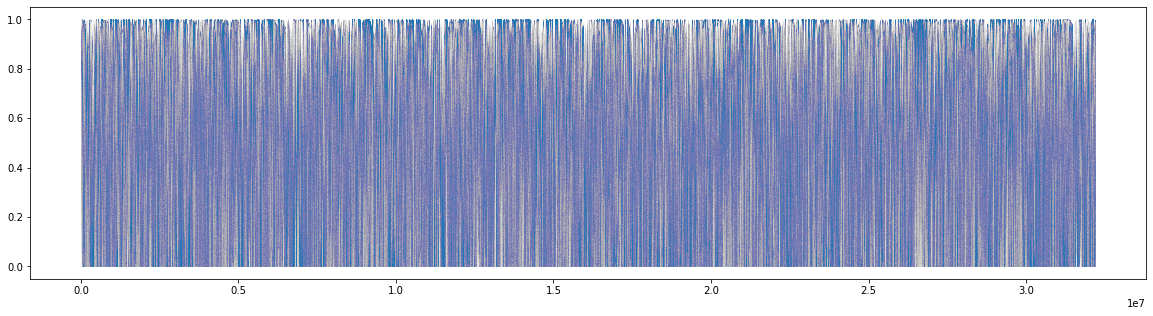

In [43]:
plt.figure(figsize=(20,5))
plt.scatter( range(len(obs_u_all)),obs_u_all,s=0.000005)
plt.show()

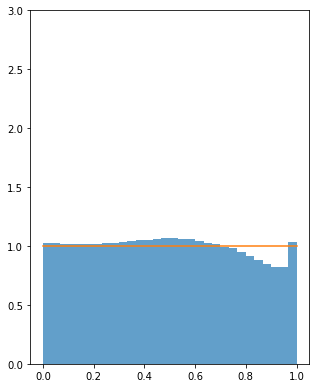

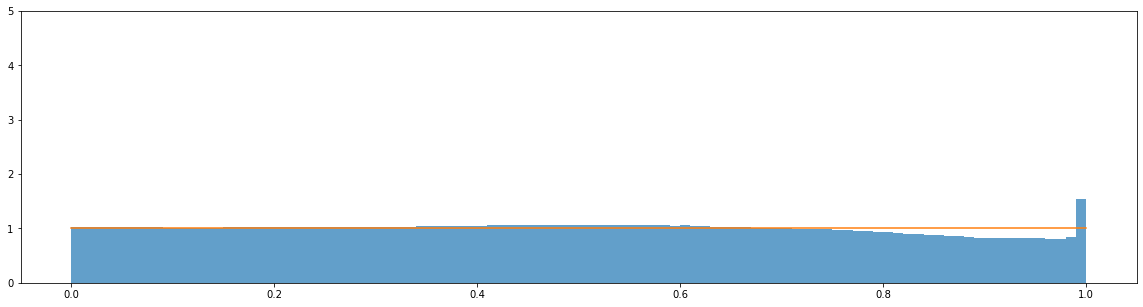

In [44]:
plt.figure(figsize=(5,6.5))
plt.hist(obs_u_all,bins=30,density=True,alpha=0.7)
plt.plot([0,1],[1,1])
plt.ylim(0,3)
plt.show()
plt.figure(figsize=(20,5))
plt.hist(obs_u_all,bins=100,density=True,alpha=0.7)
plt.plot([0,1],[1,1])   
plt.ylim(0,5)
plt.show()

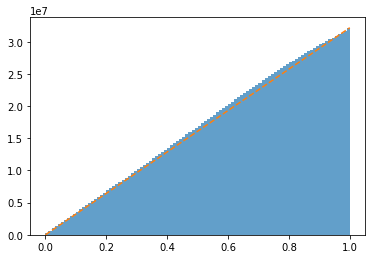

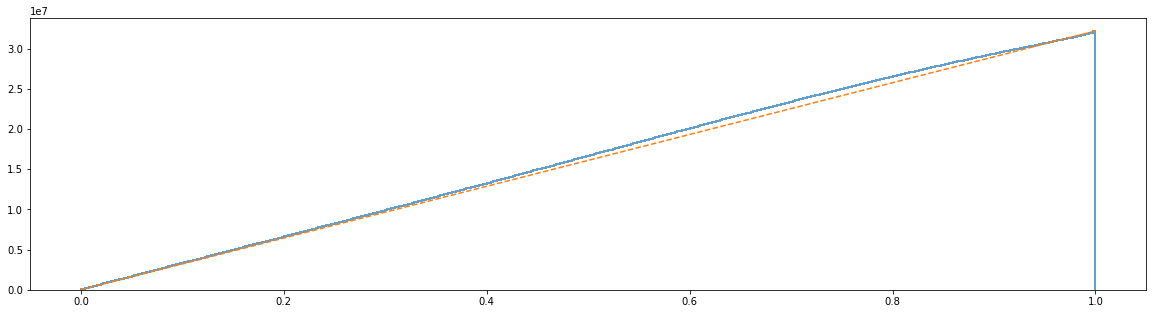

In [45]:
plt.hist(obs_u_all,bins=100,cumulative=True,alpha=0.7,align='mid')
plt.plot([0,1],[0,len(obs_u_all)],linestyle='dashed')
plt.show()
plt.figure(figsize=(20,5))
plt.hist(obs_u_all,bins=500,cumulative=True,alpha=0.7,align='mid',histtype='step',linewidth=2)
plt.plot([0,1],[0,len(obs_u_all)],linestyle='dashed')
plt.show()